In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize

In [2]:
def importAudio(target, reference, numBins, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=(numBins*2)-1, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=(numBins*2)-1, hop_length=hopSize)

    #tSTFT = librosa.feature.melspectrogram(S=tSTFT, sr=tSampleRate)
    #rSTFT = librosa.feature.melspectrogram(S=rSTFT, sr=rSampleRate)

    tDFT = librosa.stft(tArray, n_fft=(numBins*2)-1, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=(numBins*2)-1, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [3]:
def exportAudio(tAudio, mAudio, rAudio, numBins):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=math.ceil((numBins+1)/2), hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=math.ceil((numBins+1)/2), hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=math.ceil((numBins+1)/2), hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [55]:
def importAudio(target, reference, frameSize, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

def exportAudio(tAudio, mAudio, rAudio, frameSize):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [5]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2)
    spectrograms = [tSpectrogram,mSpectrogram,rSpectrogram]

    minGain = 0
    maxGain = 0
    for spectrogram in spectrograms:
        for bin in spectrogram:
            for gain in bin:
                if(gain<minGain):
                    minGain=gain
                if(gain>maxGain):
                    maxGain=gain
    
    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0],vmin=minGain,vmax=maxGain)
    
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1],vmin=minGain,vmax=maxGain)
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2],vmin=minGain,vmax=maxGain)

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [6]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,4*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='mediumseagreen', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend(loc="lower left",ncol=3)

In [7]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [8]:
def plotDynamics(tSlice,rSlice,coeff,dynamicBins):

    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)

    #abs
    tSlice = np.abs(tSlice)
    mSlice = np.abs(warp(tSlice,coeff))
    rSlice = np.abs(rSlice)



    #Level
    tLevel.plot(np.abs(tSlice),label="Unmatched",color='blue')
    tLevel.plot(np.abs(mSlice),label="Matched",color='red')
    rLevel.plot(np.abs(rSlice),color='green')

    tLevel.set_title('Target')
    tLevel.set_ylabel("Level")
    tLevel.legend()
    tLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    rLevel.set_title('Reference')
    rLevel.set_xlabel("Frame")
    rLevel.set_ylabel("Level")
    rLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    


    #Response
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tSlice, rSlice, dynamicBins)
    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=tResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=rResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)

    mDynamicResponse, mrDynamicResponse = getDynamicResponse(mSlice, rSlice, dynamicBins)
    reshape = np.flip(mDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mrResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    preDist.set_title('Distance:')
    postDist.set_title('Distance:')
    preDist.axis("off")
    postDist.axis("off")
    preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")



    #Modifier
    tMax = max(np.abs(tSlice))
    x = np.linspace(0,tMax,100)
    #plotCoeff = np.append(coeff[::-1],0)
    plotCoeff = coeff[::-1]
    y = np.polyval(plotCoeff,x)

    mod.axhline(1, color='blue')
    mod.plot(x,y, color='red')
    
    mod.set_title('Modifier')
    mod.set_xlabel("Target Level")
    mod.set_ylabel("Matched Level")

In [9]:
def integral(coeffs,a,b):
    intA = 0
    intB = 0
    for i in range(len(coeffs)):
        intA += coeffs[i] * ((a**(i+2))/(i+1))
        intB += coeffs[i] * ((b**(i+2))/(i+2))
    return intB - intA

# Quantify lack of increase- monotonicity. used to penalise loss
def LOI(coeffs,lim):
    p = np.poly1d(np.append(coeffs[::-1],0))
    der = np.polyder(p)
    roots = np.roots(der)
    
    roots = roots[np.where(roots>=0)]
    roots = roots[np.where(roots<=lim)]

    if(len(roots)%2!=0):
        secondDer = np.polyder(der)
        if(secondDer(roots[0])>0):
            roots = np.append(0,roots)
        else:
            roots = np.append(roots,lim)


    total = 0
    for i in range(0,len(roots),2):
        total += abs(integral(coeffs,roots[i],roots[i+1]))

    if(roots.size == 0):
        if(p(lim)<p(0)):
            total += abs(integral(coeffs,0,lim))
    return total/lim

In [10]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # tFreqBin may already be absolute if coming from objective funct. abs(abs()) will flatten cardinality and break functionality
    if(np.any(np.iscomplex(tFreqBin))):
        tAbs = np.abs(tFreqBin)
    else:
        tAbs=tFreqBin
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax, dynamicBins):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    
    wasserstein = wasserstein / dynamicBins
    
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

<h1>WORKSTATION</h1>

In [11]:
import numpy as np
import seaborn as sns; sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [12]:
def plotDynamicsBands(tSlices,rHist,coeff,interval):
    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)
    

    #Response
    tDynamicResponse = sumHist(dynamicResponses(tSlices,interval,plot=False))
    rDynamicResponse = rHist
    if(len(tDynamicResponse)>len(rDynamicResponse)):
        rDynamicResponse = np.pad(rDynamicResponse,(0,len(tDynamicResponse)-len(rDynamicResponse)))
    if(len(rDynamicResponse)>len(tDynamicResponse)):
        tDynamicResponse = np.pad(tDynamicResponse,(0,len(rDynamicResponse)-len(tDynamicResponse)))

    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=tResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=rResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)



    mSlices = np.zeros_like(tSlices)
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), coeff)
    mDynamicResponse = sumHist(dynamicResponses(mSlices,interval,plot=False))
    mrDynamicResponse = rHist
    if(len(mDynamicResponse)>len(mrDynamicResponse)):
        mrDynamicResponse = np.pad(mrDynamicResponse,(0,len(mDynamicResponse)-len(mrDynamicResponse)))
    if(len(mrDynamicResponse)>len(mDynamicResponse)):
        mDynamicResponse = np.pad(mDynamicResponse,(0,len(mrDynamicResponse)-len(mDynamicResponse)))
    
    reshape = np.flip(mDynamicResponse.reshape(mDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(mrDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mrResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    print("pre:",getDistance(tDynamicResponse,rDynamicResponse,interval))
    print("post:",getDistance(mDynamicResponse,rDynamicResponse,interval))
    #preDist.set_title('Distance:')
    #postDist.set_title('Distance:')
    #preDist.axis("off")
    #postDist.axis("off")
    #preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    #postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")


    
    #Modifier
    #tMax = max(np.abs(tSlice))
    #x = np.linspace(0,tMax,100)
    #plotCoeff = coeff[::-1]
    #y = np.polyval(plotCoeff,x)

    #mod.axhline(1, color='blue')
    #mod.plot(x,y, color='red')
    
    #mod.set_title('Modifier')
    #mod.set_xlabel("Target Level")
    #mod.set_ylabel("Matched Level")

In [33]:
def dynamicResponses(freqBins,interval,plot=False):
    if(np.any(np.iscomplex(freqBins))):
        absolute = np.zeros_like(freqBins)
        for i in range(len(freqBins)):
            absolute[i] = np.abs(freqBins[i])
        freqBins = absolute
      
    bins = len(freqBins)
    maxGain = 0
    for i in range(bins):
        #bin = np.abs(freqBins[i,:])
        bin = freqBins[i]
        if(max(bin)>maxGain):
            maxGain = max(bin)
    binCount = math.ceil(maxGain/interval)
    # This occurs when a negative warping.
    if(binCount==0):
        binCount=1
    

    dynamicResponses = np.zeros((bins,binCount))
    for i in range(bins):
        bin = freqBins[i]
        #bin = np.abs(freqBins[i,:])
        dynamicResponses[i]=np.histogram(bin,bins=binCount,range=(0,maxGain))[0]

    if(plot):
        plt.figure(figsize=(7*figScale,5*figScale))
        axis = np.linspace(0,math.floor(maxGain),binCount)
        ax = sns.heatmap(dynamicResponses+1,xtaicklabels=axis,cmap="magma",norm=LogNorm())
        ax.invert_yaxis()
        plt.locator_params(nbins=10)
        plt.xlabel('gain')
        plt.ylabel('frequency bin')
        plt.show()

    return dynamicResponses


In [560]:
# REVERT TO FIXED BIN COUNT

def dynamicResponses(tSlices,rSlices,interval,plot=False):
    
    # find maximums and minimums
    maxGain = 0
    minGain = 0
    for i in range(len(tSlices)):
        tBin = tSlices[i]
        rBin = rSlices[i]
        if(max(tBin)>maxGain):
            maxGain = max(tBin)
        if(max(rBin)>maxGain):
            maxGain = max(rBin)
        if(min(tBin)<minGain):
            minGain = min(tBin)
        if(min(rBin)<minGain):
            minGain = min(rBin)
    
    tDynamicResponses = np.zeros((len(tSlices),interval))
    rDynamicResponses = np.zeros((len(tSlices),interval))
    for i in range(len(tSlices)):
        tBin = tSlices[i]
        rBin = rSlices[i]
        tDynamicResponses[i]=np.histogram(tBin,bins=interval,range=(minGain,maxGain))[0]
        rDynamicResponses[i]=np.histogram(rBin,bins=interval,range=(minGain,maxGain))[0]

    if(plot):
        plt.figure(figsize=(7*figScale,5*figScale))
        axis = np.linspace(0,math.floor(maxGain),binCount)
        ax = sns.heatmap(dynamicResponses+1,xtaicklabels=axis,cmap="magma",norm=LogNorm())
        ax.invert_yaxis()
        plt.locator_params(nbins=10)
        plt.xlabel('gain')
        plt.ylabel('frequency bin')
        plt.show()

    return tDynamicResponses,rDynamicResponses


In [15]:
def bandBoundaries(numBands, numBins):
     boundaries = [0]
     for i in range(numBands):
          boundaries.append(math.floor((numBins / numBands) * (i+1)))
     return boundaries

In [16]:
def sumHist(hists):
    sumHist = np.zeros_like(hists[0])
    for hist in hists:
        sumHist += hist
    return sumHist


In [17]:
# Calculate loss between two dynamic responses
def getDistance(tHist, rHist, interval):
    A = tHist / sum(tHist)
    B = rHist / sum(rHist)
    
    if(len(A)>len(B)):
        B = np.pad(B,(0,len(A)-len(B)))
    if(len(B)>len(A)):
        A = np.pad(A,(0,len(B)-len(A)))
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))
    
    wasserstein = wasserstein * interval

    return wasserstein

In [548]:
# REVERT TO FIXED BIN COUNT

# Calculate loss between two dynamic responses
def getDistance(tHist, rHist, interval):
    A = tHist / sum(tHist)
    B = rHist / sum(rHist)
    
    if(len(A)>len(B)):
        B = np.pad(B,(0,len(A)-len(B)))
    if(len(B)>len(A)):
        A = np.pad(A,(0,len(B)-len(A)))
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))
    
    wasserstein = wasserstein / interval

    return wasserstein

In [18]:
slice1 = warp(np.abs(tAudio["STFT"][10,:]),[2])
slice2 = warp(np.abs(tAudio["STFT"][10,:]),[-2])

#slice1 = warp(tAudio["STFT"][10,:],[2])
#slice2 = warp(tAudio["STFT"][10,:],[-2])

d1 = dynamicResponses([slice1],0.1)
d2 = dynamicResponses([slice2],0.1)

print(d1)
print(d2)

NameError: name 'tAudio' is not defined

In [19]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlices, rHist, interval = params
    
    # Warp every slice of the band by the proposed coefficients
    #print("warp")
    mSlices = np.zeros_like(tSlices)
    maxT = 0
    maxM = 0
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), x)

        if(max(np.abs(tSlices[i]))>maxT):
            maxT = max(np.abs(tSlices[i]))
        if(max(np.abs(mSlices[i]))>maxM):
            maxM = max(np.abs(mSlices[i]))
    
    #print("hist")
    if(maxM/maxT>10):
        #print("very big")
        return 10000000
    # Derive histograms for each slice
    mHists = dynamicResponses(mSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)
    
    #print("distance")
    distance = getDistance(mHist, rHist, interval) + (LOI(x,maxT)*1000)
    return distance

# perform multi bin dual annealing
def findMin(tSlices,rHist,interval,order,searchSize,plot=False):
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlices,rHist,interval))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamicsBands(tSlices, rHist, sol['x'], interval)
    return sol['x']

In [547]:
# REVERT TO FIXED BIN COUNT

# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlices, rSlices, interval = params
    
    # Warp every slice of the band by the proposed coefficients
    mSlices = np.zeros_like(tSlices)
    maxT = 0
    maxM = 0
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), x)

        if(max(np.abs(tSlices[i]))>maxT):
            maxT = max(np.abs(tSlices[i]))
        if(max(np.abs(mSlices[i]))>maxM):
            maxM = max(np.abs(mSlices[i]))
    
    limitScaler = 0
    if(maxM/maxT>1):
        limitScaler = (maxM/maxT) * 10
    
    # Derive histograms for each slice
    mHists, rHists = dynamicResponses(mSlices,rSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)
    rHist = sumHist(rHists)
    
    distance = getDistance(mHist, rHist, interval) + (LOI(x,maxT)*1000) + limitScaler
    return distance

# perform multi bin dual annealing
def findMin(tSlices,rSlices,interval,order,searchSize,plot=False):
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlices,rSlices,interval))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamicsBands(tSlices, rSlices, sol['x'], interval)
    return sol['x']

In [20]:
def findMatchings(tAudio,rAudio,interval,boundaries,order,searchSize,plot=False):
    coeffs = np.zeros((len(boundaries)-1,order))
    
    for i in range(len(boundaries)-1):
        print("band",i)
        tSlices = tAudio["STFT"][boundaries[i]:boundaries[i+1]]
        rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[i]:boundaries[i+1]],interval))
        result = findMin(tSlices,rHist,interval=interval,order=order,searchSize=searchSize,plot=True)
        coeffs[i]=result
    return coeffs

In [561]:
#revert to fixed bin count
def findMatchings(tAudio,rAudio,interval,boundaries,order,searchSize,plot=False):
    coeffs = np.zeros((len(boundaries)-1,order))
    
    for i in range(len(boundaries)-1):
        print("band",i)
        tSlices = tAudio["STFT"][boundaries[i]:boundaries[i+1]]
        rSlices = rAudio["STFT"][boundaries[i]:boundaries[i+1]]
        result = findMin(tSlices,rSlices,interval=interval,order=order,searchSize=searchSize,plot=plot)
        coeffs[i]=result
    return coeffs

In [21]:
def interpolate(y1,y2,p):
    p = p*100
    o = (2/(1+(math.e**(-p/30))))-1
    interpolated = y1 + ((y2-y1)*o)
    return interpolated

In [71]:
def plotMatchings(tAudio, coeffs, boundaries):
    mAudio = np.zeros_like(tAudio["STFT"])

    plots = [None] * len(tAudio["STFT"])
    type = [None] * len(tAudio["STFT"])
    centres = np.zeros(len(boundaries)-1)

    # warp centres
    for i in range(len(centres)):
        centres[i] = boundaries[i+1] - ((boundaries[i+1] - boundaries[i]) / 2)

        mAudio[int(centres[i]),:] = warp(tAudio["STFT"][int(centres[i]),:], coeffs[i])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][int(centres[i]),:])),100)
        y = np.polyval(np.append(coeffs[i][::-1],0),x)
        plots[int(centres[i])] = [x,y]
        type[int(centres[i])] = "SA"

    # interpolate between centres
    for i in range(len(centres)-1):
        for j in range(int(centres[i])+1,int(centres[i+1])):
            interAmount = (int(centres[i]) - j) / (int(centres[i])-int(centres[i+1]))

            m1 = warp(tAudio["STFT"][j,:], coeffs[i])
            m2 = warp(tAudio["STFT"][j,:], coeffs[i+1])
            mAudio[j,:] = interpolate(m1,m2,interAmount)
            
            x = np.linspace(0,max(np.abs(tAudio["STFT"][j,:])),100)
            y1 = np.polyval(np.append(coeffs[i][::-1],0),x)
            y2 = np.polyval(np.append(coeffs[i+1][::-1],0),x)
            y = interpolate(y1,y2,interAmount)
            plots[j] = [x,y]
            type[j] = "Inter"

    # boundaries
    for i in range(int(boundaries[0]),int(centres[0])):
        mAudio[i,:] = warp(tAudio["STFT"][i,:], coeffs[0])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][i,:])),100)
        y = np.polyval(np.append(coeffs[0][::-1],0),x)
        plots[i] = [x,y]
        type[i] = "Bound"
    for i in range(int(centres[-1])+1,int(boundaries[-1])):
        mAudio[i,:] = warp(tAudio["STFT"][i,:], coeffs[-1])

        x = np.linspace(0,max(np.abs(tAudio["STFT"][i,:])),100)
        y = np.polyval(np.append(coeffs[-1][::-1],0),x)
        plots[i] = [x,y]
        type[i] = "Bound"

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(plots))[::-1]:
        match type[i]:
            case "SA":
                color="red"
                linewidth=2
            case "Inter":
                color="blue"
                linewidth=1
            case "Bound":
                color="mediumseagreen"
                linewidth=1
                
        if(plots[i]!=None):
            ax.plot(plots[i][0],plots[i][1],zs=i, zdir='y',color=color,linewidth=linewidth)
            ax.plot(plots[i][0],plots[i][0],zs=i, zdir='y',color=color,linewidth=linewidth,alpha=0.2)
    

    ax.set_zlabel("Matched Level")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

    return mAudio

base the max gain off the max from both the reference and the target. this means that scaling only has to star happening during the optimisation process.
have many bins. the matching quality will not be impeded from a higher bin count.
when performing the individual matchings, the y limit of the target will be based off the maximum y limit. this is to ensure both target and refernce histograms have a shared limit.
bins only need to be added on top in the case that the matched audio reaches a new global max gain. in this case, only need to add empty bins in ref. quantised. if 1 bin represents 1dB, only add bins if new gain exceeds 1dB etc.

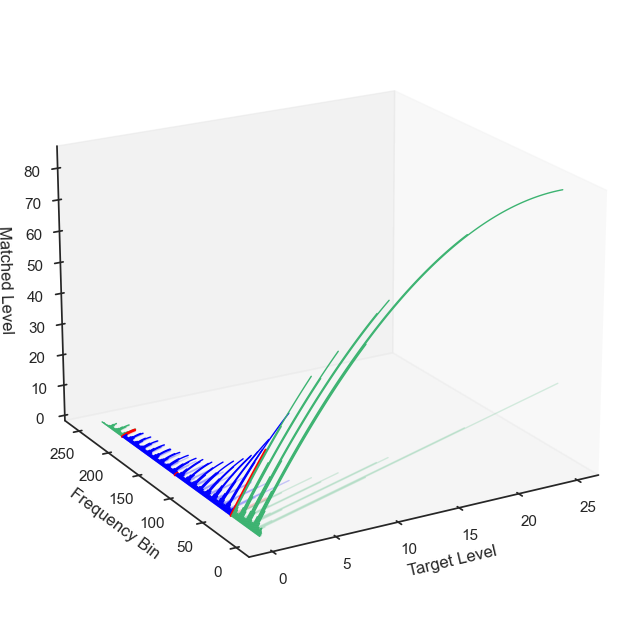

Target


Matched


Reference


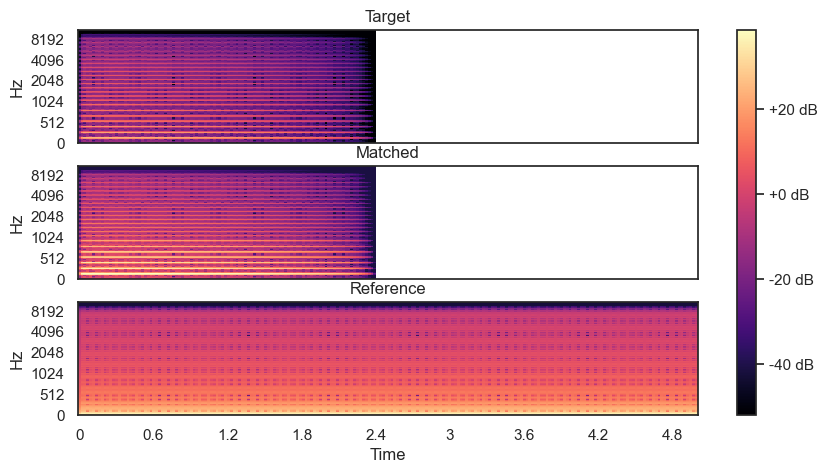

In [74]:

matchedAudio = plotMatchings(tAudio, coeffs, boundaries)
mAudio = {"STFT":matchedAudio,"sampleRate":tAudio["sampleRate"]}
plotSpectrogram(tAudio,mAudio,rAudio)
exportAudio(tAudio, mAudio, rAudio, frameSize=frameSize)

257
band 0


C:\Users\mrozi\AppData\Local\Temp\ipykernel_1652\2540151215.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  binCount = math.ceil(maxGain/interval)
C:\Users\mrozi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)


pre: 6.197997318585547
post: 2.1170940170940176
band 1
pre: 0.9901071688862386
post: 0.8368200490293514
band 2
pre: 0.5318815013582456
post: 0.4802267607500165


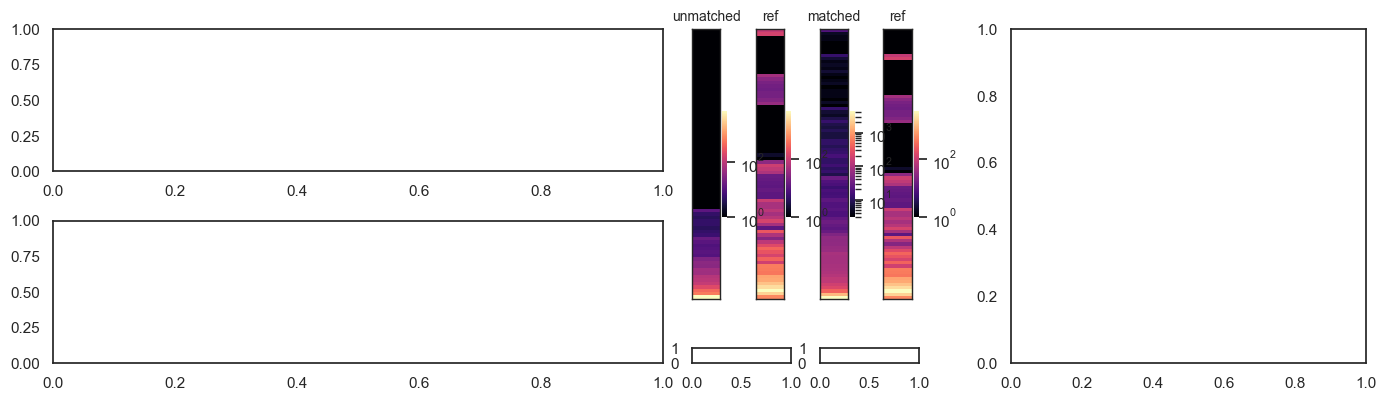

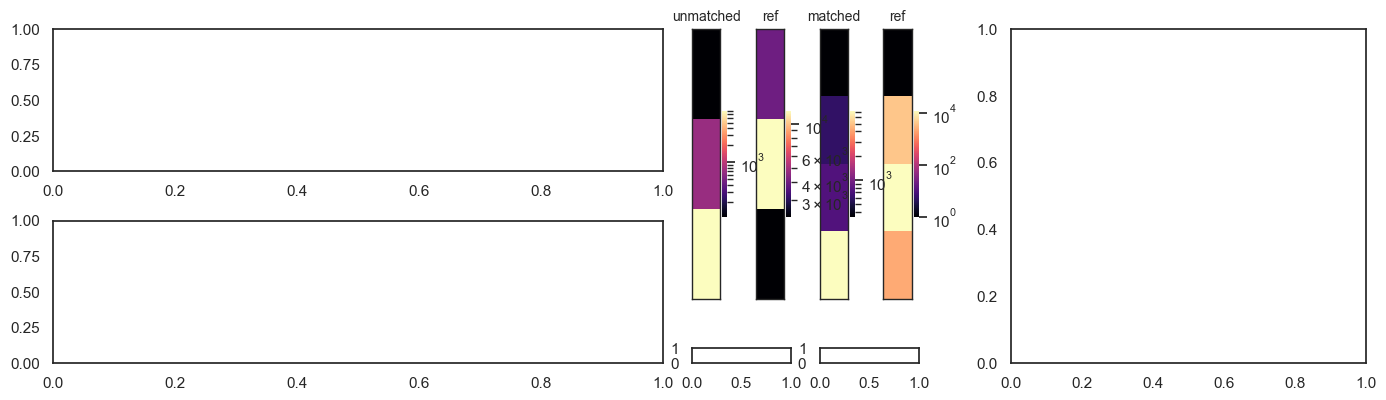

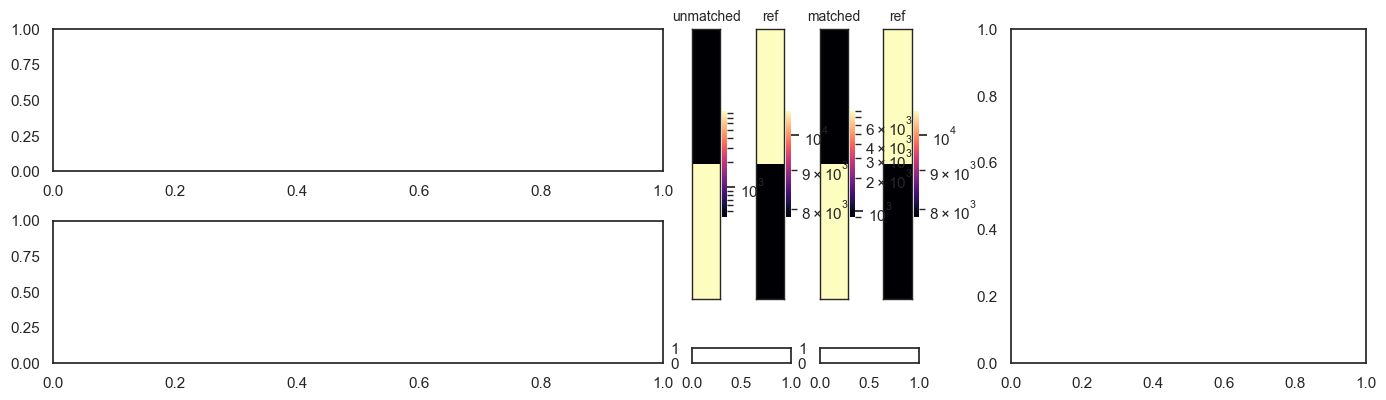

In [57]:
frameSize = 512
hopSize=512
figScale=1

numBands = 3
interval = 1

tAudio, rAudio = importAudio(target="tonequiet.wav",reference="100.wav", frameSize=frameSize, output=False)

numBins = len(tAudio["STFT"])
print(numBins)

boundaries = bandBoundaries(numBands, numBins)

coeffs = findMatchings(tAudio,rAudio,interval,boundaries,order=2,searchSize=10)

#tSlices = tAudio["STFT"][boundaries[0]:boundaries[1]]
#rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[0]:boundaries[1]],interval))

#result = findMin(tSlices,rHist,interval=interval,order=1,searchSize=100,plot=True)

In [56]:
frameSize = 512
hopSize=512
figScale=1

numBands = 3
interval = 1

tAudio, rAudio = importAudio(target="tonequiet.wav",reference="100.wav", frameSize=frameSize, output=False)
exportAudio(tAudio,tAudio,rAudio,frameSize=frameSize)

Target


Matched


Reference


In [40]:
coeffs=[[ 6.80038242, -0.13569767],
       [ 2.38872534, -0.41666704],
       [ 1.92588615, -0.65395763]]

array([[ 6.6047547 , -0.03247345],
       [-0.0736549 ,  0.12587987],
       [ 4.77790712, -0.42917252]])

<h1>BACK TO IT</h1>

In [13]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

In [14]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlice, rSlice, dynamicBins = params

    mSlice = warp(np.abs(tSlice), x)
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
    mMax = max(np.abs(mSlice))
    rMax = max(np.abs(rSlice))
    
    return getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins)# + (LOI(x,max(np.abs(tSlice)))*1000)

# perform dual annealing
def findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']

# perform powell minimisation
def powell(tSlice,rSlice,initial,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))
    #print(initial)
    #sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    sol = optimize.minimize(objective, method="Powell", x0=initial, bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']


In [69]:
def plotModifiers(coeffs,maxes,optimisation,plotRange=None):
    maxT = 0
    maxM = 0

    if(type(plotRange) != tuple):
        plotRange = (0,len(coeffs))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(plotRange[0],plotRange[1]):
        x = np.linspace(0,maxes[i],100)
        plotCoeff = coeffs[i][::-1]
        y = np.polyval(plotCoeff,x)
        if(optimisation[i]=="SA"):
            color="red"
        else:
            color="blue"
        ax.plot(x,y,zs=i, zdir='y',color=color)
        ax.plot(x,np.ones(100),zs=i, zdir='y',color=color, alpha=0.2)

        if(maxes[i]>maxT):
            maxT=maxes[i]
        if(max(y)>maxM):
            maxM=max(y)

    ax.set_zlim(0, maxM)
    ax.set_xlim(0, maxT)
    ax.set_zlabel("Multiplication")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

In [164]:
def plotModifiers(coeffs,centres,tHifi,tAudio):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    bins = len(tHifi["STFT"])
    
    sa=0
    for i in range(bins):
        if(i in centres):
            x = np.linspace(0,max(np.abs(tAudio["STFT"][sa,:])),100)
            y = np.polyval(coeffs[sa][::-1],x)

            ax.plot(x,y,zs=i, zdir='y',color="red")
            ax.plot(x,np.ones(100),zs=i, zdir='y',color="red", alpha=0.2)

            sa+=1
        else:
            x = np.linspace(0,1,100)
            y = np.polyval([1],x)

            ax.plot(x,y,zs=i, zdir='y',color="blue")
            ax.plot(x,np.ones(100),zs=i, zdir='y',color="blue", alpha=0.2)
    
    ax.set_zlabel("Multiplication")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

In [159]:
5 in [1,2,5]

True

<h1>Different matching strategies</h1>

In [16]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatching(tAudio,rAudio,dynamicBins,order,searchSize,jump,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="SA"

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
                optimisation[i]="Powell"
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"

    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [17]:
# Simulated annealing in centre bin. propagate local minimisations up and down. if minimisation worse than default, perform S.A. instead. scale starting coefficients if derived from smaller bin.
def findMatchingCentreScaleDistanceCheck(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # Centre S.A
    i=math.floor(bins/2)
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))
        
        if(maxes[i]>maxes[i+1]):
            initial = coeffs[i+1] * (maxes[i+1]/maxes[i])
        else:
            initial = coeffs[i+1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"

    # Propagate up
    i=math.floor(bins/2)
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))

        if(maxes[i]>maxes[i-1]):
            initial = coeffs[i-1] * (maxes[i-1]/maxes[i])
        else:
            initial = coeffs[i-1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [160]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatchingNew(tAudio,rAudio,tHifi,dynamicBins,order,searchSize,plot=False):
    bins = len(tHifi["STFT"])
    bands = len(tAudio["STFT"])

    coeffs = np.zeros((bands,order))
    #maxes = np.zeros(bins)
    #optimisation = [None] * bins

    centres = []
    for i in range(bands):
        centres.append(int((bins/bands)*(i+0.5)))

    for band in range(bands):
        tSlice = tAudio["STFT"][band,:]
        rSlice = rAudio["STFT"][band,:]

        coeffs[band]=findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=plot)
        #maxes[int(centres[i])]=max(np.abs(tSlice))
        #optimisation[int(centres[i])]="SA"
    
    if(plot):
        plotModifiers(coeffs,centres,tHifi,tAudio)
    return coeffs, centres

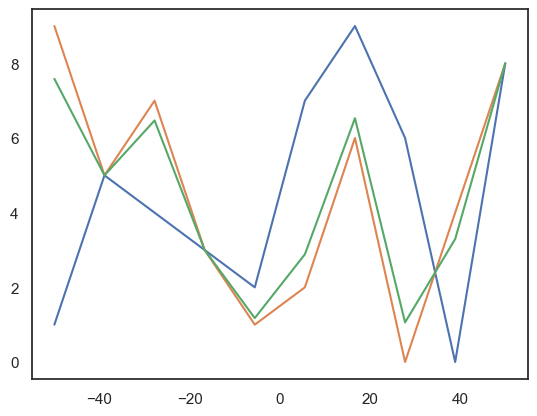

In [167]:
plotCoeff1 = [1,3,2]
plotCoeff2 = [2,50,300]
x = np.linspace(-50,50,10)
y1 = np.polyval(plotCoeff1,x)
y2 = np.polyval(plotCoeff2,x)

y1 = np.array((1,5,4,3,2,7,9,6,0,8))
y2 = np.array((9,5,7,3,1,2,6,0,4,8))
plt.plot(x,y1)
plt.plot(x,y2)

p = 70
o = (2/(1+(math.e**(-p/30))))-1

interpolate = y1 + ((y2-y1)*o)

plt.plot(x,interpolate)


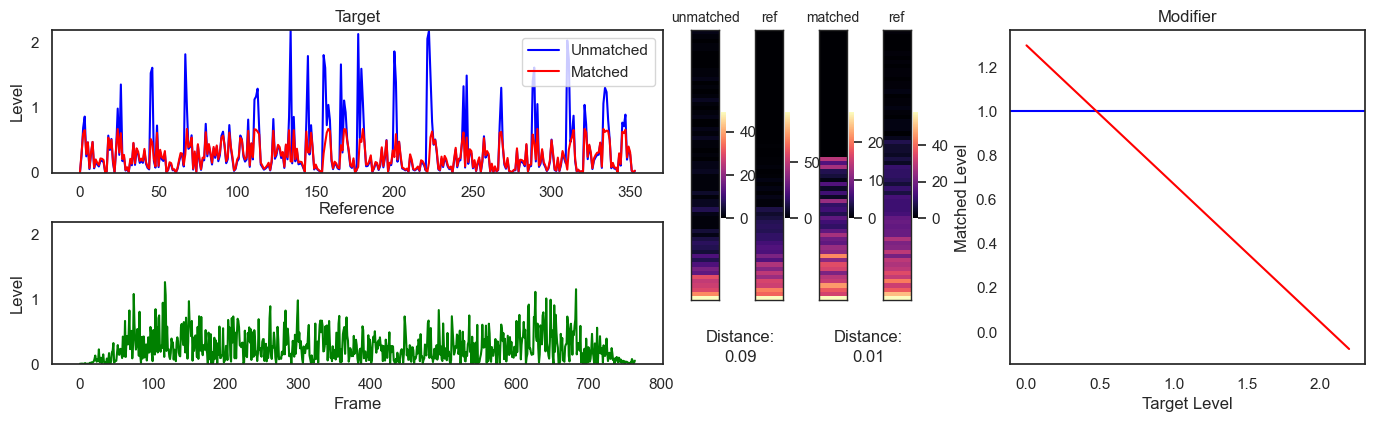

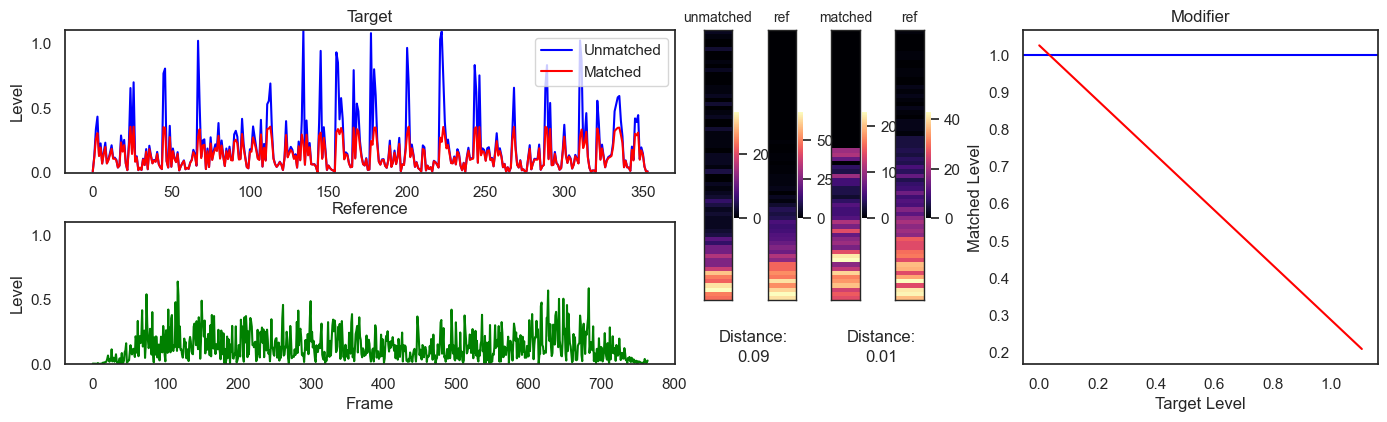

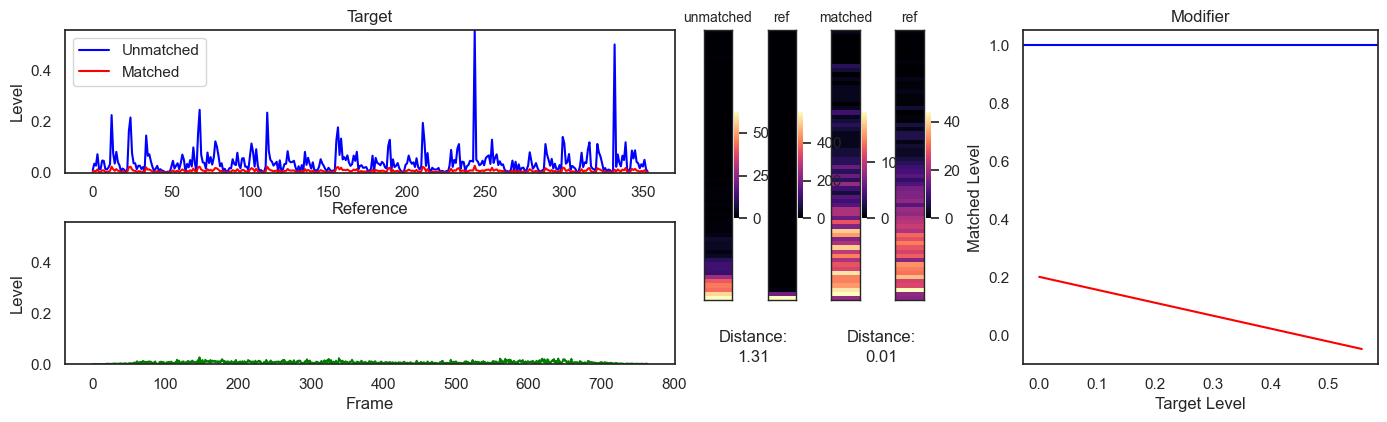

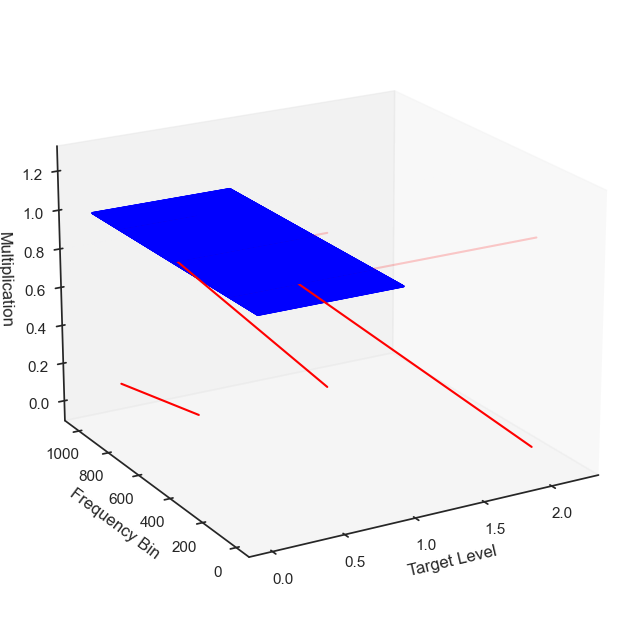

In [165]:
coeffs, centres = findMatchingNew(tAudio,rAudio,tHifi,dynamicBins=64,order=2,searchSize=100,plot=True)

In [ ]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatchingNew(tAudio,rAudio,tHifi,dynamicBins,order,searchSize,plot=False):
    bins = len(tHifi["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins
    

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="SA"

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
                optimisation[i]="Powell"
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"

    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [18]:
def match(tAudio,coeffs):
    mAudio = copy.deepcopy(tAudio)
    for i in range(len(tAudio["STFT"])):
        bin = tAudio["STFT"][i,:]
        mAudio["STFT"][i,:] = warp(bin,coeffs[i])
    return mAudio

In [19]:
def totalDistance(tAudio,mAudio,rAudio,dynamicBins):
    preDist = 0
    postDist = 0
    for i in range(len(tAudio["STFT"])):
        tSlice = tAudio["STFT"][i,:]
        mSlice = mAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]

        tMax = max(np.abs(tSlice))
        mMax = max(np.abs(mSlice))
        rMax = max(np.abs(rSlice))

        tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
        preDist += getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
        
        mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
        postDist += getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins)
    
    print("pre:",preDist/dynamicBins)
    print("post:",postDist/dynamicBins)

<h1>Execution</h1>

In [20]:
frameSize=2048
hopSize=512

figScale = 1

In [1]:
#tAudio, rAudio = importAudio(target="100.wav",reference="tonequiet.wav", output=False)

tAudio, rAudio = importAudio(target="100.wav",reference="tonequiet.wav", numBands=3,output=False)
tHifi, rHifi = importAudio(target="100.wav",reference="tonequiet.wav", numBands=1024,output=False)
#tHifi, rHifi = importAudio(target="audio_mono.wav",reference="audo3_mono.wav", numBands=1024,output=False)
#plotAmpPhase("audio_mono.wav")


#coeffs = findMatching(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,jump=8,plot=True,plotRange=(0,33))
#coeffs = findMatchingCentreScaleDistanceCheck(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,plot=True)
#mAudio = match(tAudio,coeffs)
#totalDistance(tAudio,mAudio,rAudio,64)
#plotSpectrogram(tAudio, mAudio, rAudio)


#tSlice = tAudio["STFT"][0,:]
#rSlice = rAudio["STFT"][0,:]
#findMin(tSlice,rSlice,dynamicBins=64,order=2,searchSize=100,plot=True)
#coeffs = findMatchingNew(tAudio,rAudio,tHifi,dynamicBins=64,order=2,searchSize=100,plot=True)

#tSlice = tAudio["STFT"][100,:]
#mSlice1 = warp(np.abs(tSlice), [-1])
#mSlice2 = warp(np.abs(tSlice), [1])
#mSlice1==mSlice2

#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[-18.73538423,64.65852413,-67.87420381,],64)
#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[18.73538423,-64.65852413,67.87420381,],64)


#np.abs(tAudio["STFT"][100,5]*-10)

#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

#[-67.87420381,64.65852413,-18.73538423,0]


#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)
plotSpectrogram(tAudio, tAudio, rAudio)
plotSpectrogram(tHifi, tHifi, rHifi)



#exportAudio(tAudio, mAudio, rAudio)

NameError: name 'importAudio' is not defined

In [183]:
maxTHifi = 0
for i in range(len(tHifi["STFT"])):
    maxVal = max(np.abs(tHifi["STFT"][6,:]))
    if(maxVal>maxTHifi):
        maxTHifi = maxVal

maxTLofi = 0
for i in range(len(tAudio["STFT"])):
    maxVal = max(np.abs(tAudio["STFT"][6,:]))
    if(maxVal>maxTLofi):
        maxTLofi = maxVal

maxRHifi = 0
for i in range(len(rHifi["STFT"])):
    maxVal = max(np.abs(rHifi["STFT"][6,:]))
    if(maxVal>maxRHifi):
        maxRHifi = maxVal

maxRLofi = 0
for i in range(len(rAudio["STFT"])):
    maxVal = max(np.abs(rAudio["STFT"][6,:]))
    if(maxVal>maxRLofi):
        maxRLofi = maxVal

tAudio["STFT"] = tAudio["STFT"] * maxTHifi/maxTLofi
rAudio["STFT"] = rAudio["STFT"] * maxRHifi/maxRLofi

In [180]:
maxTHifi/maxTLofi

215.47173

In [181]:
maxRHifi/maxRLofi

1742.1671

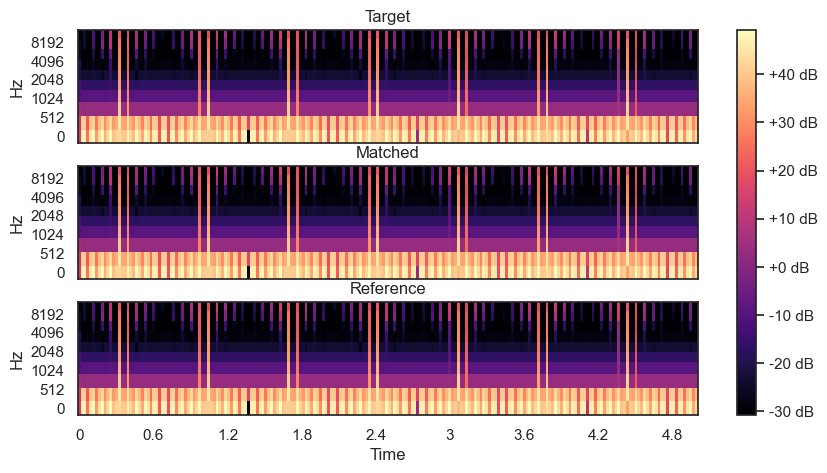

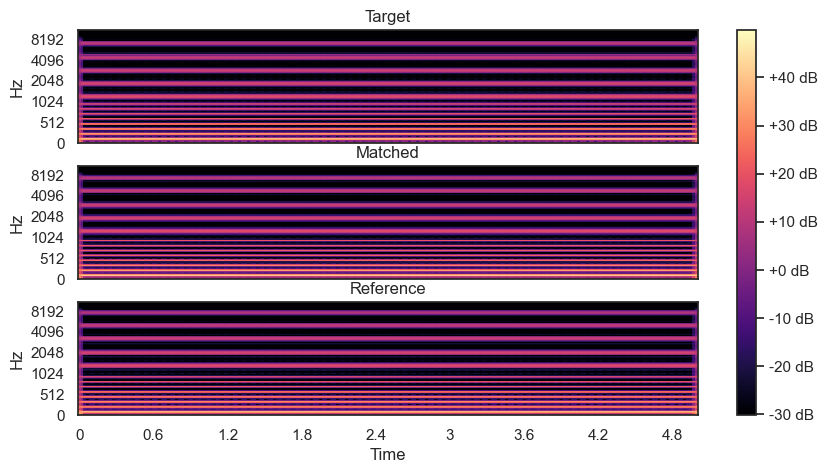

In [186]:
plotSpectrogram(tAudio, tAudio, tAudio)
plotSpectrogram(tHifi, tHifi, tHifi)

In [153]:
print(max(np.abs(tHifi["STFT"][6,:])))
print(max(np.abs(tAudio["STFT"][0,:])))

316.91165
2.1938403


In [ ]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference
